   Edited by Sizhuo Li
   
   Author: Ankit Kariryaa, University of Bremen

In [43]:
import os
import rasterio  # I/O raster data (netcdf, height, geotiff, ...)

import rasterio.warp             # Reproject raster samples
from rasterio import windows
import fiona                     # I/O vector data (shape, geojson, ...)
import geopandas as gps

from shapely.geometry import Point, Polygon
from shapely.geometry import mapping, shape

import numpy as np               # numerical array manipulation
import os
from tqdm import tqdm
import PIL.Image
import PIL.ImageDraw

from itertools import product
from tensorflow.keras.models import load_model

import sys
from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo, image_normalize

# Had to run sudo apt-get install libsm6 libxrender1 libfontconfig1 to get this running
# More details: https://stackoverflow.com/a/52530843/1446289
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [44]:
%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
print(tf.__version__)

2.9.1


In [45]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/RasterAnalysis.py)
# Please provide required info in the file before continuing with this notebook. 
 
from config import RasterAnalysis
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import RasterAnalysis

config = RasterAnalysis.Configuration()

In [46]:
# Load a pretrained model
OPTIMIZER = adaDelta
model = load_model(config.trained_model_path, custom_objects={'tversky': tversky, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy, 'specificity':specificity, 'sensitivity':sensitivity}, compile=False)
model.compile(optimizer=OPTIMIZER, loss=tversky, metrics=[dice_coef, dice_loss, accuracy, specificity, sensitivity])

In [47]:
## ADDED AJP 8/17/2022 to fix an error
#from tensorflow.keras.utils import multi_gpu_model

In [48]:
# Methods to add results of a patch to the total results of a larger area. The operator could be min (useful if there are too many false positives), max (useful for tackle false negatives)
def addTOResult(res, prediction, row, col, he, wi, operator = 'MAX'):
    currValue = res[row:row+he, col:col+wi]
    newPredictions = prediction[:he, :wi]
# IMPORTANT: MIN can't be used as long as the mask is initialed with 0!!!!! If you want to use MIN initial the mask with -1 and handle the case of default value(-1) separately.
    if operator == 'MIN': # Takes the min of current prediction and new prediction for each pixel
        currValue [currValue == -1] = 1 #Replace -1 with 1 in case of MIN
        resultant = np.minimum(currValue, newPredictions) 
    elif operator == 'MAX':
        resultant = np.maximum(currValue, newPredictions)
    else: #operator == 'REPLACE':
        resultant = newPredictions    
# Alternative approach; Lets assume that quality of prediction is better in the centre of the image than on the edges
# We use numbers from 1-5 to denote the quality, where 5 is the best and 1 is the worst.In that case, the best result would be to take into quality of prediction based upon position in account
# So for merge with stride of 0.5, for eg. [12345432100000] AND [00000123454321], should be [1234543454321] instead of [1234543214321] that you will currently get. 
# However, in case the values are strecthed before hand this problem will be minimized
    res[row:row+he, col:col+wi] =  resultant
    return (res)

In [49]:
# Methods that actually makes the predictions
def predict_using_model(model, batch, batch_pos, mask, operator):
    tm = np.stack(batch, axis = 0)
    prediction = model.predict(tm)
    for i in range(len(batch_pos)):
        (col, row, wi, he) = batch_pos[i]
        p = np.squeeze(prediction[i], axis = -1)
        # Instead of replacing the current values with new values, use the user specified operator (MIN,MAX,REPLACE)
        mask = addTOResult(mask, p, row, col, he, wi, operator)
    return mask
    

def detect_tree(ndvi_img, pan_img, width=256, height=256, stride = 128, normalize=True):
    assert ndvi_img.meta['width'] == pan_img.meta['width'] and ndvi_img.meta['height'] == pan_img.meta['height']
    nols, nrows = ndvi_img.meta['width'], ndvi_img.meta['height']
    meta = ndvi_img.meta.copy()
    if 'float' not in meta['dtype']: #The prediction is a float so we keep it as float to be consistent with the prediction. 
        meta['dtype'] = np.float32
    offsets = product(range(0, nols, stride), range(0, nrows, stride))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
#     print(nrows, nols)

    mask = np.zeros((nrows, nols), dtype=meta['dtype'])

#     mask = mask -1 # Note: The initial mask is initialized with -1 instead of zero to handle the MIN case (see addToResult)
    batch = []
    batch_pos = [ ]
    for col_off, row_off in  tqdm(offsets):
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ndvi_img.transform)
        patch = np.zeros((height, width, 2)) #Add zero padding in case of corner images
        ndvi_sm = ndvi_img.read(window=window)
        pan_sm = pan_img.read(window=window)
        temp_im = np.stack((ndvi_sm, pan_sm), axis = -1)
        temp_im = np.squeeze(temp_im)
        
        if normalize:
            temp_im = image_normalize(temp_im, axis=(0,1)) # Normalize the image along the width and height i.e. independently per channel
            
        patch[:window.height, :window.width] = temp_im
        batch.append(patch)
        batch_pos.append((window.col_off, window.row_off, window.width, window.height))
        if (len(batch) == config.BATCH_SIZE):
            mask = predict_using_model(model, batch, batch_pos, mask, 'MAX')
            batch = []
            batch_pos = []
            
    # To handle the edge of images as the image size may not be divisible by n complete batches and few frames on the edge may be left.
    if batch:
        mask = predict_using_model(model, batch, batch_pos, mask, 'MAX')
        batch = []
        batch_pos = []

    return(mask, meta)

In [50]:
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'str', 'canopy': 'float:15.2',},
    }

def drawPolygons(polygons, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    for polygon in polygons:
        xy = [(point[1], point[0]) for point in polygon]
        draw.polygon(xy=xy, outline=255, fill=255)
    mask = np.array(mask)#, dtype=bool)   
    return(mask)

def transformToXY(polygons, transform):
    tp = []
    for polygon in polygons:
        rows, cols = zip(*polygon)
        x,y = rasterio.transform.xy(transform, rows, cols)
        tp.append(list(zip(x,y)))
    return (tp)

def createShapefileObject(polygons, meta, wfile):
    with fiona.open(wfile, 'w', crs=meta.get('crs').to_dict(), driver='ESRI Shapefile', schema=schema) as sink:
        for idx, mp in enumerate(polygons):
            try:
#                 poly = Polygon(poly)
    #             assert mp.is_valid
    #             assert mp.geom_type == 'Polygon'
                sink.write({
                    'geometry': mapping(mp),
                    'properties': {'id': str(idx), 'canopy': mp.area},
                })
            except:
                print("An exception occurred in createShapefileObject; Polygon must have more than 2 points")
#                 print(mp)

# Generate a mask with polygons
def transformContoursToXY(contours, transform = None):
    tp = []
    for cnt in contours:
        pl = cnt[:, 0, :]
        cols, rows = zip(*pl)
        x,y = rasterio.transform.xy(transform, rows, cols)
        tl = [list(i) for i in zip(x, y)]
        tp.append(tl)
    return (tp)


def mask_to_polygons(maskF, transform):
    # first, find contours with cv2: it's much faster than shapely
    th = 0.5
    mask = maskF.copy()
    mask[mask < th] = 0
    mask[mask >= th] = 1
    mask = ((mask) * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    #Convert contours from image coordinate to xy coordinate
    contours = transformContoursToXY(contours, transform)
    if not contours: #TODO: Raise an error maybe
        print('Warning: No contours/polygons detected!!')
        return [Polygon()]
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])

    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []

    for idx, cnt in enumerate(contours):
        if idx not in child_contours: #and cv2.contourArea(cnt) >= min_area: #Do we need to check for min_area??
            try:
                poly = Polygon(
                    shell=cnt,
                    holes=[c for c in cnt_children.get(idx, [])])
                           #if cv2.contourArea(c) >= min_area]) #Do we need to check for min_area??
                all_polygons.append(poly)
            except:
                pass
#                 print("An exception occurred in createShapefileObject; Polygon must have more than 2 points")
    print(len(all_polygons))
    return(all_polygons)

def create_contours_shapefile(mask, meta, out_fn):
    res = mask_to_polygons(mask, meta['transform'])
#     res = transformToXY(contours, meta['transform'])
    createShapefileObject(res, meta, out_fn)


def writeMaskToDisk(detected_mask, detected_meta, wp, write_as_type = 'uint8', th = 0.5, create_countors = False):
    # Convert to correct required before writing
    if 'float' in str(detected_meta['dtype']) and 'int' in write_as_type:
        print(f'Converting prediction from {detected_meta["dtype"]} to {write_as_type}, using threshold of {th}')
        detected_mask[detected_mask<th]=0
        detected_mask[detected_mask>=th]=1
        detected_mask = detected_mask.astype(write_as_type)
        detected_meta['dtype'] =  write_as_type
        
    with rasterio.open(wp, 'w', **detected_meta) as outds:
        outds.write(detected_mask, 1)

    if create_countors:
        wp = wp.replace(image_type, output_shapefile_type)
        create_contours_shapefile(detected_mask, detected_meta, wp)

In [51]:
# Predict trees in the all the files in the input image dir
# Depending upon the available RAM, images may not to be split before running this cell.
# Use the Auxiliary-2-SplitRasterToAnalyse if the images are too big to be analysed in memory.
all_files = []
for root, dirs, files in os.walk(config.input_image_dir):
    for file in files:
        if file.endswith(config.input_image_type) and file.startswith(config.ndvi_fn_st):
             all_files.append((os.path.join(root, file), file))
# print(all_files)
for fullPath, filename in all_files:
    outputFile = os.path.join(config.output_dir, filename.replace(config.ndvi_fn_st, config.output_prefix) )
    if not os.path.isfile(outputFile) or config.overwrite_analysed_files: 
        with rasterio.open(fullPath) as ndvi:
            with rasterio.open(fullPath.replace(config.ndvi_fn_st, config.pan_fn_st)) as pan:
                print(fullPath)
                detectedMask, detectedMeta = detect_tree(ndvi, pan, width = config.WIDTH, height = config.HEIGHT, stride = config.STRIDE) # WIDTH and HEIGHT should be the same and in this case Stride is 50 % width
                #Write the mask to file
                writeMaskToDisk(detectedMask, detectedMeta, outputFile, write_as_type = config.output_dtype, th = 0.5, create_countors = False)                
    else:
        print('File already analysed!', fullPath)

/home/ubuntu/data/indata/ndvi_m_3210310_ne.tif


198it [00:09, 133.98it/s]

7/7 [==============================] - 1s 145ms/step


387it [00:12, 130.13it/s]

7/7 [==============================] - 1s 142ms/step


591it [00:15, 133.06it/s]

7/7 [==============================] - 1s 143ms/step


797it [00:18, 136.62it/s]

7/7 [==============================] - 1s 143ms/step


991it [00:21, 133.36it/s]

7/7 [==============================] - 1s 144ms/step


1187it [00:23, 134.18it/s]

7/7 [==============================] - 1s 144ms/step


1391it [00:26, 131.98it/s]

7/7 [==============================] - 1s 143ms/step


1594it [00:29, 135.02it/s]

7/7 [==============================] - 1s 143ms/step


1791it [00:32, 133.06it/s]

7/7 [==============================] - 1s 143ms/step


1985it [00:35, 133.74it/s]

7/7 [==============================] - 1s 143ms/step


2196it [00:38, 137.18it/s]

7/7 [==============================] - 1s 143ms/step


2389it [00:40, 133.02it/s]

7/7 [==============================] - 1s 151ms/step


2587it [00:43, 135.41it/s]

7/7 [==============================] - 1s 143ms/step


2688it [00:45, 59.12it/s] 


3/3 [==============================] - 0s 143ms/step
Converting prediction from float32 to uint8, using threshold of 0.5


(array([0.0000000e+00, 1.1754997e-38, 1.1755086e-38, ..., 9.9999976e-01,
        9.9999988e-01, 1.0000000e+00], dtype=float32),
 array([71174364,       14,        7, ...,    39433,    86961,  4879237]))

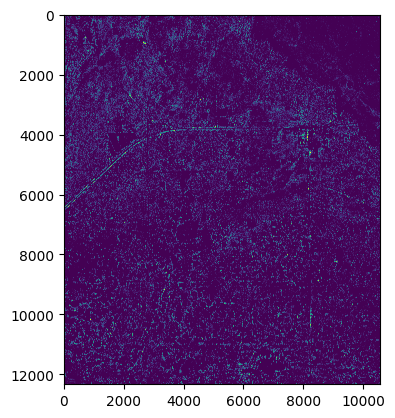

In [42]:
# Display extracted image
sampleImage = 'm_3210310_ne.tif'
fn = os.path.join(config.output_dir, config.output_prefix + sampleImage )
predicted_img = rasterio.open(fn)
p = predicted_img.read()
np.unique(p, return_counts=True)
plt.imshow(p[0])